In [0]:
import os
import itertools
import codecs
import re
import datetime
import editdistance
import numpy as np
import pylab
import random
import editdistance
%tensorflow_version 1.x
import keras
import pickle
import json
from itertools import cycle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda, Flatten
from keras.layers import add, concatenate
from keras.layers import GRU, CuDNNGRU, Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from imageio import imread, imwrite
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive

K.set_image_data_format('channels_last')
np.random.seed(0)

Using TensorFlow backend.


In [0]:
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
t_images = np.load(folder + "t_images.npy")
t_images2 = np.load(folder + "batchx.npy")
e_labels = np.load(folder + "e_labels.npy")
e_labels2 = np.load(folder + "batchye.npy")
label_lens = np.load(folder + "label_lens.npy")
label_lens2 = np.load(folder + "batchylen.npy")

In [0]:
len(t_images), len(e_labels)

(1415, 1415)

In [0]:
# Download and import model file
!cp '/content/gdrive/My Drive/University/tfg/model/model.py' .
from model import create_model

In [0]:
# Take a test set, only from the turing sequences
turing_lines = len(t_images)
mask = np.full(turing_lines, False)
mask[:50] = True
np.random.shuffle(mask)
t_images_test = t_images[mask]
e_labels_test = e_labels[mask]
label_lens_test = label_lens[mask]
t_images = t_images[~mask]
e_labels = e_labels[~mask]
label_lens = label_lens[~mask]

In [0]:
len(t_images), len(t_images_test)

(1365, 50)

In [0]:
t_images = np.concatenate([t_images, t_images2], axis=0)
e_labels = np.concatenate([e_labels, e_labels2], axis=0)
label_lens = np.concatenate([label_lens, label_lens2], axis=0)

In [0]:
def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]
  
t_images_train, e_labels_train, label_lens_train = \
  unison_shuffled_copies(t_images, e_labels, label_lens)

In [0]:
# Invert values (black background, white letters)
t_images_train = 1 - t_images_train
t_images_test = 1 - t_images_test

In [0]:
# t_images_train, e_labels_train, label_lens_train = \
#   shuffle(t_images, e_labels, label_lens, random_state=99)

In [0]:
# Load alphabet
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
with open(folder + 'alphabet.pickle', 'rb') as handle:
  alphabet = pickle.load(handle)
with open(folder + 'ixchar.pickle', 'rb') as handle:
  ix_to_char = pickle.load(handle)

In [0]:
# Define a parameters dictionary
params = {}

# Data Parameters 
params['img_h'] = t_images.shape[2]
params['img_w'] = t_images.shape[1]
params['input_shape'] = (params['img_w'], params['img_h'], 1)
params['max_string_len'] = int(max([length for length in label_lens]))

# Network parameters
params['conv_filters'] = 32
params['num_convs'] = 2
params['kernel_size'] = (3,3)
params['pool_size'] = 2
params['time_dense_size'] = 64
params['rnn1_size'] = 128
params['rnn2_size'] = 128
params['ctc_cut'] = 2
params['output_size'] = len(alphabet) + 1
params['act'] = 'relu'

batch_size = 64

In [0]:
# Save parameters for use in production
with open('/content/gdrive/My Drive/University/tfg/model/params.json', 'w') as file:
  file.write(json.dumps(params, indent=2))

In [0]:
# A tensor where all values are the same, is required by ctc loss
ctc_input_length = (params['img_w'] // (params['pool_size'] ** params['num_convs'])) - params['ctc_cut']
ctc_input_length = np.expand_dims(np.array([ctc_input_length] * len(t_images)), 1)
ctc_input_length.shape

(1982, 1)

In [0]:
def label_to_text(ixes):
  ret = []
  for c in ixes:
    if c == len(alphabet) or c == -1:  # CTC Blank
      ret.append("")
    else:
      ret.append(ix_to_char[c])
  return "".join(ret)

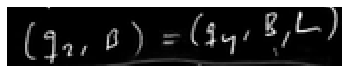

The label is:  (q2,B)=(q4,B,L)
Should match:  [15.] 15


In [0]:
# Explore the data, check that everything is correct
i = random.randint(0, len(t_images_train)-1)
plt.imshow(np.squeeze(t_images_train[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(e_labels_train[i]))
print("Should match: ", label_lens_train[i], len(label_to_text(e_labels_train[i])))

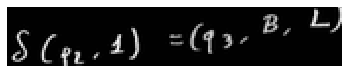

The label is:  d(q2,1)=(q3,B,L)


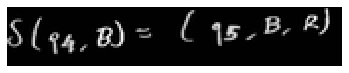

The label is:  d(q4,B)=(q5,B,R)


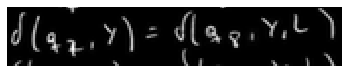

The label is:  d(q7,Y)=d(q8,Y,L)


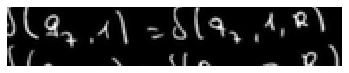

The label is:  d(q7,1)=d(q7,1,R)


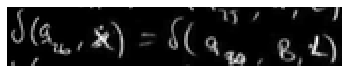

The label is:  d(q26,X)=d(q30,B,L)


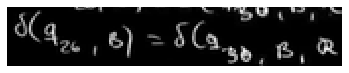

The label is:  d(q26,B)=d(q30,B,R


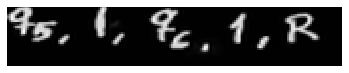

The label is:  q5,1,q6,1,R


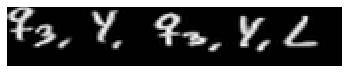

The label is:  q3,Y,q3,Y,L


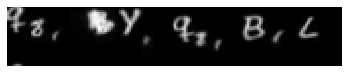

The label is:  q8,Y,q8,B,L


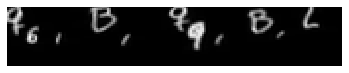

The label is:  q6,B,q9,B,L


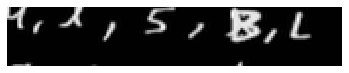

The label is:  1,1,5,B,L


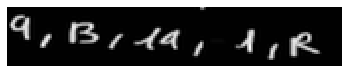

The label is:  9,B,19,1,R


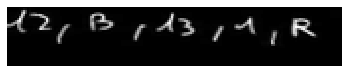

The label is:  12,B,13,1,R


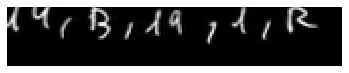

The label is:  14,B,19,1,R


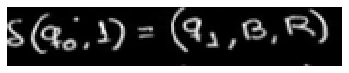

The label is:  d(q0,1)=(q1,B,R)


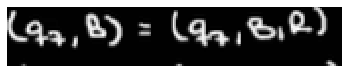

The label is:  (q7,B)=(q7,B,R)


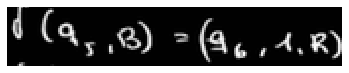

The label is:  d(q5,B)=(q6,1,R)


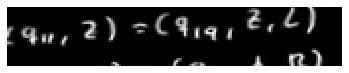

The label is:  (q11,Z)=(q19,Z,L)


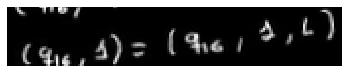

The label is:  (q16,1)=(q16,1,L)


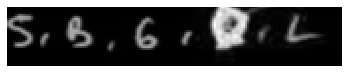

The label is:  5,B,6,0,L


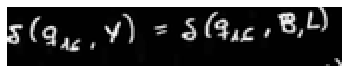

The label is:  d(q16,Y)=d(q16,B,L)


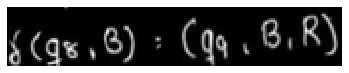

The label is:  d(q8,B)=(q9,B,R)


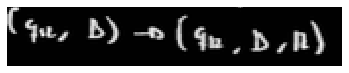

The label is:  (q10,B)=(q12,B,R)


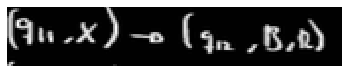

The label is:  (q11,X)=(q12,B,R)


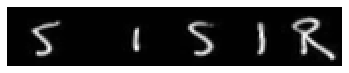

The label is:  5 1 5 1 R


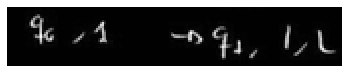

The label is:  q6,1=q1,1,L


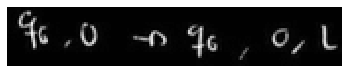

The label is:  q6,0=q6,0,L


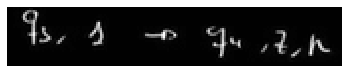

The label is:  q3,1=q4,Z,R


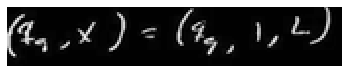

The label is:  (q9,X)=(q9,1,L)


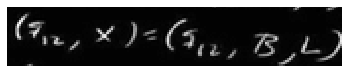

The label is:  (q12,X)=(q12,B,L)


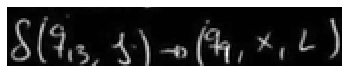

The label is:  d(q13,1)=(q9,X,L)


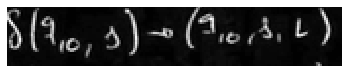

The label is:  d(q10,1)=(q10,1,L)


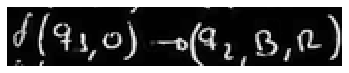

The label is:  (q3,0)=(q2,B,R)


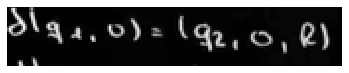

The label is:  d(q1,0)=(q2,0,R)


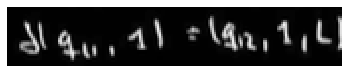

The label is:  d(q11,1)=(q12,1,L)


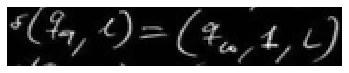

The label is:  d(q,1)=(q10,1,L)


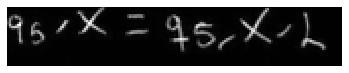

The label is:  q5,X=q5,X,L


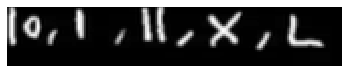

The label is:  10,1,11,X,L


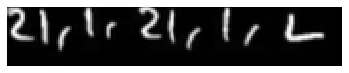

The label is:  21,1,21,1,L


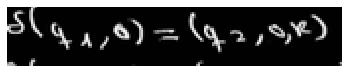

The label is:  d(q1,0)=(q2,0,R)


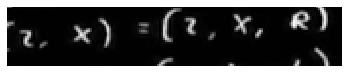

The label is:  (2,X)=(2,X,R)


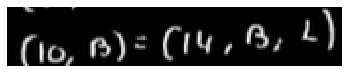

The label is:  (10,B)=(14,B,L)


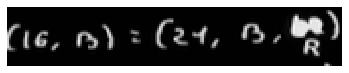

The label is:  (16,B)=(21,B,R)


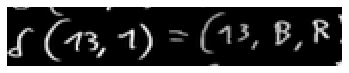

The label is:  d(13,1)=(13,B,R)


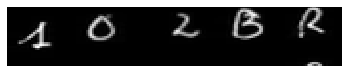

The label is:  1 0 2 B R


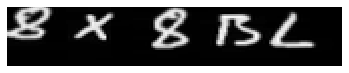

The label is:  8 X 8 B L


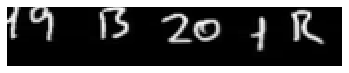

The label is:  19 B 20 1 R


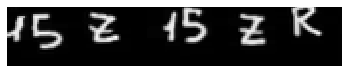

The label is:  15 Z 15 Z R


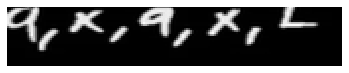

The label is:  9,X,9,X,L


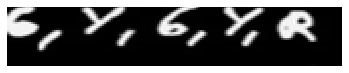

The label is:  6,Y,6,Y,R


In [0]:
# Show all test images
for i in range(len(t_images_test)):
  plt.imshow(np.squeeze(t_images_test[i].T), cmap='gray')
  plt.axis('off')
  plt.show()
  print("The label is: ", label_to_text(e_labels_test[i]))

In [0]:
# Check shapes
t_images.shape, e_labels.shape, ctc_input_length.shape, label_lens.shape

((1982, 170, 30, 1), (1982, 19), (1982, 1), (1982, 1))

In [0]:
model, decoder_models = create_model(params, gpu=True, two_rnns=False)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
#plot_model(model, to_file='model.png')

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 170, 30, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 170, 30, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 85, 15, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 85, 15, 32)   0           max1[0][0]                       
____________________________________________________________________________________________

In [0]:
# Data Augmentation
data_gen_args = dict(
    rotation_range = 2,
    zoom_range = (1,1.1),
    shear_range = 8,
    fill_mode = "constant",
    cval = 0.0,
    data_format = 'channels_last',
)
image_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(**data_gen_args)
image_flow = image_datagen.flow(t_images_train, batch_size=1, shuffle=False)
test_flow = test_datagen.flow(t_images_test, batch_size=1, shuffle=False)

In [0]:
def get_data_round():
  image_round = []
  for _ in range(len(t_images_train)):
    image_round.append(np.squeeze(next(image_flow),axis=0))
  return [image_round, e_labels_train, ctc_input_length[:len(t_images_train)], 
          label_lens_train]

In [0]:
def get_test_round():
  image_round = []
  for _ in range(len(t_images_test)):
    image_round.append(np.squeeze(next(test_flow),axis=0))
  return [image_round, e_labels_test, ctc_input_length[:len(t_images_test)], 
          label_lens_test]

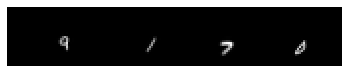

9170


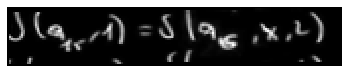

d(q15,1)=d(q16,X,L)


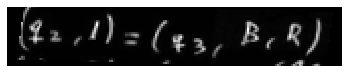

(q2,1)=(q3,B,R)


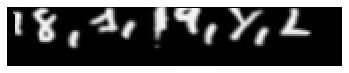

18,1,19,Y,L


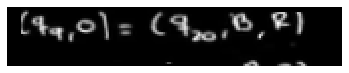

(q9,0)=(q20,B,R)


In [0]:
# Testing the data comming from the generator
testing_imgs, testing_lbs, _, _ = get_data_round()
r = random.randint(0, len(t_images) - 6)
for i in range(r, r+5):
  img = testing_imgs[i]
  plt.imshow(np.squeeze(img.T), cmap='gray')
  plt.axis('off')
  plt.show()
  print(label_to_text(testing_lbs[i]))

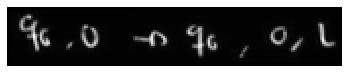

q6,0=q6,0,L


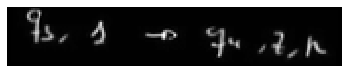

q3,1=q4,Z,R


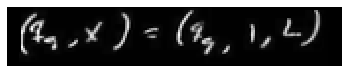

(q9,X)=(q9,1,L)


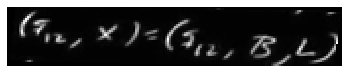

(q12,X)=(q12,B,L)


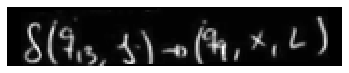

d(q13,1)=(q9,X,L)


In [0]:
# Testing the data comming from the test generator
testing_imgs, testing_lbs, _, _ = get_test_round()
r = random.randint(0, len(t_images_test) - 6)
for i in range(r, r+5):
  img = testing_imgs[i]
  plt.imshow(np.squeeze(img.T), cmap='gray')
  plt.axis('off')
  plt.show()
  print(label_to_text(testing_lbs[i]))

In [0]:
# Edit distance metric ...
def edit_distance(y_true, y_pred):
  total = 0
  for true, pred in zip(y_true, y_pred):
    true = label_to_text(list(np.squeeze(true)))
    pred = label_to_text(list(np.squeeze(pred)))
    total += editdistance.eval(true, pred)
  return total / len(y_true)

In [0]:
number = 16
# model.load_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model_{number}.h5')

In [0]:
# To name weight files
i = 0

In [0]:
# For plotting
losses = []
edit_values = []

In [0]:
def print_predictions(show=False, images=t_images_test, labels=e_labels_test):
  decoder0, decoder1, decoder2 = decoder_models
  # Look at the test results
  total_edit_distance = 0
  for j in range(len(images)):
    decoded0 = np.array(decoder0([images[j:j+1], ctc_input_length[j:j+1]]))
    decoded1 = np.array(decoder1([images[j:j+1], ctc_input_length[j:j+1]]))
    decoded2 = np.array(decoder2([images[j:j+1], ctc_input_length[j:j+1]]))

    if decoded0.size < 2 or decoded1.size < 2 or decoded2.size < 2:
      print("Predictions are empty")
      break

    if show:
      plt.imshow(np.squeeze(images[j].T), cmap='gray')
      plt.axis('off')
      plt.show()
      print("True label:   ", label_to_text(list(np.squeeze(labels[j]))))
      print("Prediction 1: ", label_to_text(list(np.squeeze(decoded0))))
      print("Prediction 2: ", label_to_text(list(np.squeeze(decoded1))))
      print("Prediction 3: ", label_to_text(list(np.squeeze(decoded2))))
    distance = editdistance.eval(label_to_text(labels[j]),
                        label_to_text(list(np.squeeze(decoded0))))
    total_edit_distance += distance
    if show: print(f"Edit distance: {distance}")
    
  average_distance = total_edit_distance / len(images)
  print(f"Average test edit distance: {average_distance}")
  edit_values.append(average_distance)

In [0]:
# Initial fast training
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(0.001))
history = model.fit(
        x = get_data_round(),
        y = np.zeros(len(t_images_train)),
        validation_data=(get_test_round(), np.zeros(len(t_images_test))),
        batch_size=128,
        epochs=10,
        verbose=0,
        #validation_split=0.15,
)

In [0]:
# Long training
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0005))
for j in range(45):
  data_round = get_data_round()
  test_round = get_test_round()
  history = model.fit(
          x = data_round,
          y = np.zeros(len(t_images_train)),
          validation_data=(test_round, np.zeros(len(t_images_test))),
          batch_size=64,
          epochs=5,
          verbose=0,
          #shuffle=False,
         )
  print(f"Iteration {j:0>2}: loss: {np.min(history.history['loss']):5.2f}, validation loss: {np.min(history.history['val_loss']):5.2f}")
  # if (j+1) % 10 == 0:
  #   i += 1
  #   print(f"Saving weights, model: {i}!")
  #   model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/modelnew_{i}.h5')

Iteration 00: loss: 20.16, validation loss: 21.96
Iteration 01: loss: 16.58, validation loss: 17.68
Iteration 02: loss: 14.01, validation loss: 13.77
Iteration 03: loss: 12.18, validation loss: 11.62
Iteration 04: loss: 10.75, validation loss: 10.37
Iteration 05: loss:  9.41, validation loss:  9.14
Iteration 06: loss:  8.40, validation loss:  8.46
Iteration 07: loss:  7.62, validation loss:  7.92
Iteration 08: loss:  6.98, validation loss:  7.04
Iteration 09: loss:  6.37, validation loss:  6.72
Iteration 10: loss:  5.94, validation loss:  6.39
Iteration 11: loss:  5.50, validation loss:  5.92
Iteration 12: loss:  5.18, validation loss:  5.82
Iteration 13: loss:  4.77, validation loss:  5.45
Iteration 14: loss:  4.41, validation loss:  4.78
Iteration 15: loss:  4.15, validation loss:  5.00
Iteration 16: loss:  3.97, validation loss:  4.63
Iteration 17: loss:  3.68, validation loss:  4.61
Iteration 18: loss:  3.54, validation loss:  3.79
Iteration 19: loss:  3.28, validation loss:  4.25


In [0]:
# Precision training
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0005))
for j in range(1):
  data_round = get_data_round()
  test_round = get_test_round()
  history = model.fit(
          x = data_round,
          y = np.zeros(len(t_images_train)),
          validation_data=(test_round, np.zeros(len(t_images_test))),
          batch_size=128,
          epochs=5,
          verbose=0,
         )
  print(f"Iteration {j:0>2}: loss: {np.min(history.history['loss']):5.2f}, validation loss: {np.min(history.history['val_loss']):5.2f}")

Iteration 00: loss:  1.07, validation loss:  3.25


In [0]:
print_predictions()

Average test edit distance: 1.26


In [0]:
print_predictions(show=True, images=t_images_train[:20], labels=e_labels_train[:20])

In [0]:
edit_values

[0.8]

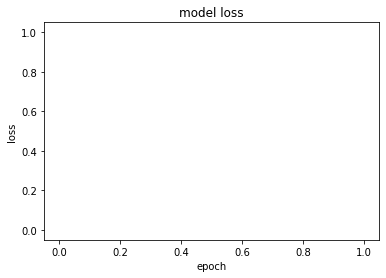

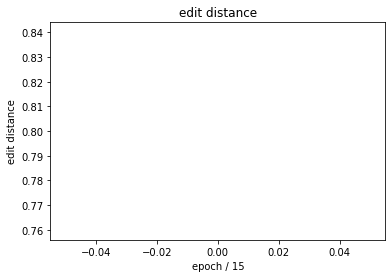

In [0]:
# Plot graphcs
plt.plot(losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(edit_values)
plt.title('edit distance')
plt.ylabel('edit distance')
plt.xlabel('epoch / 15')
plt.show()

In [0]:
# Save final model for production
model.save_weights('/content/gdrive/My Drive/University/tfg/model/weights.h5')

In [0]:
# Load production weights
# model.load_weights('/content/gdrive/My Drive/University/tfg/backend/weights.h5')

In [0]:
# Compute training dataset edit distance
decoder0, decoder1, decoder2 = decoder_models
total_edit_distance = 0
for j in range(len(t_images_train)):
  decoded0 = decoder0([t_images_train[j:j+1], ctc_input_length[j:j+1]])[0]
  true = label_to_text(list(np.squeeze(e_labels_train[j])))
  if decoded0.size:
    predicted = label_to_text(list(np.squeeze(decoded0, axis=0)))
  else:
    predicted = ""
  distance = editdistance.eval(true, predicted)
  total_edit_distance += distance
  
print(f"Average training edit distance: {total_edit_distance / len(t_images_train)}")

In [0]:
# # Compute training dataset edit distance (in batch, WIP)
# total_edit_distance = 0
# decoded0 = decoder0([t_images_train, ctc_input_length[:len(t_images_train)]])[0]
# trues = []
# preds = []
# for label in list(np.squeeze(e_labels_train[j])):
#   trues.append(label_to_text(label))
# for dec in decoded0:
#   preds.append(label_to_text(list(dec)))

# for true, pred in trues, preds:
#   distance = editdistance.eval(true, pred)
#   total_edit_distance += distance
  
# print(f"Average edit distance: {total_edit_distance / len(t_images_train)}")